<h1 class="sc-cZSric sc-boYqxe eNXgIn bvFneb"><span style="background-color: #2dc26b;"><strong>Heart Attack Dataset</strong></span></h1>

<div class="sc-UEtKG dGqiYy sc-flttKd cguEtd">
<div class="sc-fqwslf gsqkEc">
<div class="sc-cBQMlg kAHhUk">
<h2 class="sc-dcKlJK sc-cVttbi gqEuPW ksnHgj">About Dataset</h2>
</div>
</div>
</div>
<div class="sc-jgvlka jFuPjz">
<div class="sc-gzqKSP ktvwwo">
<div>
<div class="sc-etVRix kMRejg sc-bMmLMY ZURWJ">
<p>The heart attack datasets were collected at Zheen hospital in Erbil, Iraq, from January 2019 to May 2019. The attributes of this dataset are: age, gender, heart rate, systolic blood pressure, diastolic blood pressure, blood sugar, ck-mb and troponin with negative or positive output. According to the provided information, the medical dataset classifies either heart attack or none. The gender column in the data is normalized: the male is set to 1 and the female to 0. The glucose column is set to 1 if it is &gt; 120; otherwise, 0. As for the output, positive is set to 1 and negative to 0.</p>
<p>Institutions<br />University of Kurdistan Hewler</p>
<p>Categories<br />Medicine, Heart Disease</p>
<p>DOI: Rashid, Tarik A.; Hassan, Bryar (2022), &ldquo;Heart Attack Dataset&rdquo;, Mendeley Data, V1, doi: 10.17632/wmhctcrt5v.1</p>
</div>
</div>
</div>
</div>

<p><a title="Download DataSet" href="https://www.kaggle.com/datasets/fatemehmohammadinia/heart-attack-dataset-tarik-a-rashid/data">https://www.kaggle.com/datasets/fatemehmohammadinia/heart-attack-dataset-tarik-a-rashid/data</a></p>

<p><em>Importamos las librer&iacute;as necesarias</em></p>

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

## Funciones Auxiliares

In [68]:
#Funcion para reemplazar Outliers
def reemplazar_outliers(df, columnas, estrategia='median'):
    df = df.copy()
    
    for col in columnas:
        if col not in df.columns:
            print(f"La columna '{col}' no está en el DataFrame. Se omite.")
            continue
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"La columna '{col}' no es numérica. Se omite.")
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Definir el valor de reemplazo según la estrategia
        if estrategia == 'median':
            valor = df[col].median()
        elif estrategia == 'mean':
            valor = df[col].mean()
        elif estrategia == 'most_frequent':
            valor = df[col].mode()[0]
        else:
            raise ValueError("La estrategia debe ser 'median', 'mean' o 'most_frequent'.")

        # Reemplazar outliers
        df.loc[(df[col] < limite_inferior) | (df[col] > limite_superior), col] = valor

    return df

In [69]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [70]:
#Remover la variable objetivo o predictora del particionado
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [71]:
#Comparar dos modelos
def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, "Conjunto con Outliers:", metric(y_pred, y, average='weighted'))
    print(metric.__name__, "Cobjunto Sin Outliers:", metric(y_prep_pred, y_prep, average='weighted'))

In [72]:
#Detecta la cantidad de Outliers
def detectar_outliers(df):
    resumen = []

    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)]
        resumen.append({
            'columna': col,
            'outliers': len(outliers)
        })
    return pd.DataFrame(resumen)


# Extraccion

## Lectura del conjunto de datos

In [73]:
df = pd.read_csv('Medicaldataset.csv')

## Visualización del conjunto de datos

In [74]:
df.head(10)

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative
5,58,0,61,112,58,87.0,1.83,0.004,negative
6,32,0,40,179,68,102.0,0.71,0.003,negative
7,63,1,60,214,82,87.0,300.00,2.370,positive
8,44,0,60,154,81,135.0,2.35,0.004,negative
9,67,1,61,160,95,100.0,2.84,0.011,negative


In [75]:
#Observamos el dataset
df.describe()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.191812,0.659591,78.336619,127.170584,72.269143,146.634344,15.274306,0.360942
std,13.647315,0.474027,51.630270,26.122720,14.033924,74.923045,46.327083,1.154568
min,14.000000,0.000000,20.000000,42.000000,38.000000,35.000000,0.321000,0.001000
25%,47.000000,0.000000,64.000000,110.000000,62.000000,98.000000,1.655000,0.006000
50%,58.000000,1.000000,74.000000,124.000000,72.000000,116.000000,2.850000,0.014000
75%,65.000000,1.000000,85.000000,143.000000,81.000000,169.500000,5.805000,0.085500
max,103.000000,1.000000,1111.000000,223.000000,154.000000,541.000000,300.000000,10.300000


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1319 non-null   int64  
 1   Gender                    1319 non-null   int64  
 2   Heart rate                1319 non-null   int64  
 3   Systolic blood pressure   1319 non-null   int64  
 4   Diastolic blood pressure  1319 non-null   int64  
 5   Blood sugar               1319 non-null   float64
 6   CK-MB                     1319 non-null   float64
 7   Troponin                  1319 non-null   float64
 8   Result                    1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


In [77]:
#Buscamos si hay Desbalanceo de clases para tomar medidas
df["Result"].value_counts()

Result
positive    810
negative    509
Name: count, dtype: int64

NameError: name 'plt' is not defined

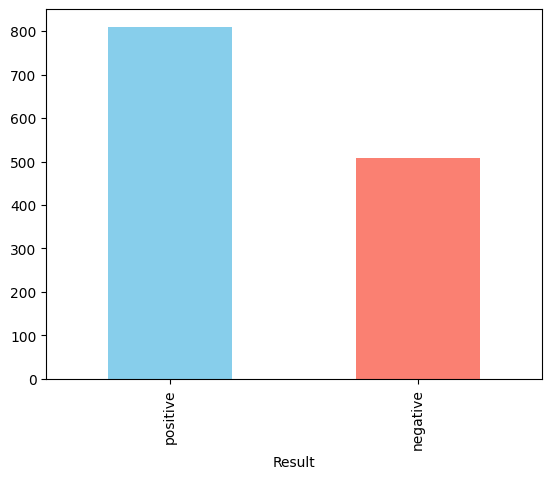

In [78]:
#Buscamos si hay desbalance de clases
df["Result"].value_counts().plot(kind='bar', color=["skyblue", "salmon"])
plt.title('Distribución de clases')
plt.xlabel('Clase (0 = Negativo, 1 = Positivo)')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<p><em>No hay desbalance de clases</em></p>

# Transformacion

In [ ]:
#Buscamos valores Nulos.
df.isnull().sum()

In [ ]:
# Creamos una copia independiente del DF
data = df.copy()

In [ ]:
#Hacemos un resumen de la cantidad de outliers que contiene el DF
outliers = detectar_outliers(data)
outliers

In [ ]:
#Hacemos una copia independiente del df y pasamos la funcion que sustituye los outliers por la mediana
columnas=['Heart rate','Systolic blood pressure','Diastolic blood pressure','Blood sugar','CK-MB','Troponin']
data_sin_outliers = reemplazar_outliers(data, columnas, estrategia='median').copy()

In [ ]:
# Transformamos la variable de salida a numérica para calcular correlaciones
X = df.copy()
X['Result'] = X['Result'].factorize()[0]

In [ ]:
#Buscamos correlaciones y estudiamos el dataset para evitar la colinealidad
corr_matrix = X.corr()
corr_matrix["Result"].sort_values(ascending=False)

In [ ]:
corr_matrix

<p><em>No se observa &nbsp;colinealidad</em></p>

##  División del conjunto de datos

In [ ]:
# Dividimos el conjunto de datos en este caso se usara el dataset que eliminamos los outliers y el que no, posteriomente compararemos
train_set, val_set, test_set = train_val_test_split(data)
train_set_WOut, val_set_WOut, test_set_WOut = train_val_test_split(data_sin_outliers)

<p><em><strong>Conjunto de datos original con outliers</strong></em></p>

In [ ]:
#removemos la variable objetivo  y los features o caracteristicas
X_train, y_train = remove_labels(train_set, 'Result')
X_val, y_val = remove_labels(val_set, 'Result')
X_test, y_test = remove_labels(test_set, 'Result')

<p><em><strong>Conjunto de datos sin Outliers</strong></em></p>

In [ ]:
#removemos la variable objetivo  y los features o caracteristicas
X_train_WOut, y_train_WOut = remove_labels(train_set_WOut, 'Result')
X_val_WOut, y_val_WOut = remove_labels(val_set_WOut, 'Result')
X_test_WOut, y_test_WOut = remove_labels(test_set_WOut, 'Result')

## Random Forests

In [ ]:
#Importamos las librerias necesarios para usar Random Forest
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Modelo entrenado con el conjunto de datos sin escalar y con Outliers
clf_rnd = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train, y_train)

In [ ]:
# Modelo entrenado con el conjunto de datos sin escalar y sin Outliers
clf_rnd_WOut = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_rnd_WOut.fit(X_train_WOut, y_train_WOut)

In [ ]:
# Predecimos con el conjunto de datos de entrenamiento en ambos conjuntos
y_train_pred = clf_rnd.predict(X_train)
y_train_prep_WOut = clf_rnd_WOut.predict(X_train_WOut)

In [ ]:
# Comparamos resultados entre el conjunto con Outliers y sin Outliers
evaluate_result(y_train_pred, y_train, y_train_prep_WOut, y_train, f1_score)

<p><em><strong>Conclusi&oacute;n: </strong>Probablemente, se est&eacute; produciendo Overffiting en ambos, haremos pruebas con los otros dos subconjuntos.</em></p>

In [ ]:
# Predecimos con el conjunto de datos de validación
y_pred = clf_rnd.predict(X_val)
y_prep_WOut = clf_rnd_WOut.predict(X_val_WOut)

In [ ]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_pred, y_val, y_prep_WOut, y_val, f1_score)

<p><em>Nos ofrece mejor resultado el modelo sin eliminar los Outliers</em></p>

In [ ]:
# Predecimos con el conjunto de datos de prueba
y_pred = clf_rnd.predict(X_test)
y_prep_WOut = clf_rnd_WOut.predict(X_test_WOut)

In [ ]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_pred, y_test, y_prep_WOut, y_test, f1_score)

<p><em><strong>Conclusi&oacute;n:</strong> No hay tanta diferencia entre ambos modelos, el que se hace con el conjunto con outliers, es ligeramente mejor; sin embargo, para buscar los par&aacute;metros &oacute;ptimos continuaremos solo con el conjunto que contiene los outliers.</em></p>

## Selección del modelo Optimo

In [ ]:
# Uso de Grid Search para selección del modelo
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 9 (3×3) combinations of hyperparameters
    {'n_estimators': [100, 500, 1000], 'max_leaf_nodes': [16, 24, 36]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [100, 500], 'max_features': [2, 3, 4]},
  ]

rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=42)

# train across 5 folds, that's a total of (9+6)*5=75 rounds of training 
grid_search = GridSearchCV(rnd_clf, param_grid, cv=5,
                           scoring='f1_weighted', return_train_score=True)

grid_search.fit(X_train, y_train)

In [ ]:
#Mejores parametros encontrados.
grid_search.best_params_

In [ ]:
# Seleccionamos el mejor modelo que encontro GridSearchCV
clf_rnd = grid_search.best_estimator_

In [ ]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = clf_rnd.predict(X_train)

In [ ]:
# Evaluación
print(classification_report(y_train, y_train_pred))
print("Matriz de Confusión:")
ConfusionMatrixDisplay.from_estimator(clf_rnd, X_train, y_train, values_format='d')

<p><em><strong>Conclusi&oacute;n:</strong> Los resultados son bastante buenos, probablemente se est&eacute; produciendo Overfiting, seguiremos haciendo pruebas.</em></p>

In [ ]:
# Predecimos con el conjunto de datos de entrenamiento
y_val_pred = clf_rnd.predict(X_val)

In [ ]:
# Evaluación
print(classification_report(y_val, y_val_pred))
print("Matriz de Confusión:")
ConfusionMatrixDisplay.from_estimator(clf_rnd, X_val, y_val, values_format='d')

<p class="" data-start="137" data-end="324">El modelo Random Forest obtuvo un excelente desempe&ntilde;o en el conjunto de prueba, alcanzando una exactitud (accuracy) del 98%. Las m&eacute;tricas por clase reflejan un rendimiento balanceado:</p>
<ul data-start="326" data-end="633">
<li class="" data-start="326" data-end="494">
<p class="" data-start="328" data-end="494">Para la clase "positive", el modelo logr&oacute; una <em data-start="378" data-end="389">precisi&oacute;n</em> y <em data-start="392" data-end="400">recall</em> del 98%, indicando una alta capacidad para identificar correctamente los casos positivos.</p>
</li>
<li class="" data-start="495" data-end="633">
<p class="" data-start="497" data-end="633">Para la clase "negative", se obtuvo un <em data-start="540" data-end="550">f1-score</em> del 97%, lo que demuestra una muy buena discriminaci&oacute;n de los casos negativos.</p>
</li>
</ul>
<p class="" data-start="635" data-end="817">El promedio ponderado de las m&eacute;tricas (precision, recall y f1-score) es tambi&eacute;n de 98%, lo que sugiere que el modelo es confiable incluso ante posibles desbalances en las clases.</p>

In [ ]:
# Predecimos con el conjunto de datos de entrenamiento
y_test_pred = clf_rnd.predict(X_test)

In [ ]:
# Evaluación
print(classification_report(y_test, y_test_pred))
print("Matriz de Confusión:")
ConfusionMatrixDisplay.from_estimator(clf_rnd, X_test, y_test, values_format='d')

<p class="" data-start="672" data-end="843"><strong>Conclusi&oacute;n:&nbsp;</strong></p>
<p class="" data-start="672" data-end="843">El modelo mostr&oacute; un rendimiento altamente consistente entre el conjunto de validaci&oacute;n y el de prueba, con mejoras leves en todas las m&eacute;tricas en el conjunto de prueba:</p>
<ul data-start="845" data-end="1279">
<li class="" data-start="845" data-end="965">
<p class="" data-start="847" data-end="965">La accuracy aument&oacute; de 98% a 99%, lo que indica que el modelo generaliza ligeramente mejor en datos no vistos.</p>
</li>
<li class="" data-start="966" data-end="1098">
<p class="" data-start="968" data-end="1098">Las clases "negative" y "positive" mantuvieron un equilibrio excelente en precisi&oacute;n, recall y F1-score en ambos conjuntos.</p>
</li>
<li class="" data-start="1099" data-end="1279">
<p class="" data-start="1101" data-end="1279">La mejora en el F1-score de la clase negativa (de 0.97 a 0.99) sugiere que el modelo ha mejorado su capacidad para detectar correctamente los casos negativos en datos nuevos.</p>
</li>
</ul>

## Importancia de Caracteristicas.

In [ ]:
#Buscamos la importancia de las caracteristicas.
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extraer importancias y ordenarlas
importancias = pd.Series(clf_rnd.feature_importances_, index=X_train.columns)
top_vars = importancias.sort_values(ascending=False)

# Gráfico mejorado
plt.figure(figsize=(10, 5))
sns.barplot(x=top_vars.values, y=top_vars.index, palette="Blues_d")
plt.title('Importancia de variables')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<h3 class="" data-start="124" data-end="181"><strong data-start="131" data-end="181">&iquest;Qu&eacute; pasa con la troponina durante un infarto?</strong></h3>
<p class="" data-start="183" data-end="432">Cuando ocurre un <strong data-start="200" data-end="219">ataque card&iacute;aco</strong>, una parte del m&uacute;sculo del coraz&oacute;n (miocardio) sufre da&ntilde;o porque no recibe suficiente ox&iacute;geno. Este da&ntilde;o hace que las c&eacute;lulas musculares se rompan y liberen su contenido en la sangre, incluyendo la <strong data-start="418" data-end="431">troponina</strong>.</p>
<table>
<thead>
<tr>
<th>Momento</th>
<th>Niveles de troponina</th>
</tr>
</thead>
<tbody>
<tr>
<td>0 horas (inicio del infarto)</td>
<td>Normales</td>
</tr>
<tr>
<td>3&ndash;6 horas despu&eacute;s</td>
<td><strong>Empiezan a elevarse</strong></td>
</tr>
<tr>
<td>12&ndash;24 horas</td>
<td><strong>Pico m&aacute;ximo</strong></td>
</tr>
<tr>
<td>5&ndash;10 d&iacute;as</td>
<td>Vuelven a valores normales</td>
</tr>
</tbody>
</table>
<p>Esto significa que <strong data-start="765" data-end="793">no se eleva de inmediato</strong>, sino que <strong data-start="804" data-end="834">hay que esperar unas horas</strong> despu&eacute;s del inicio del dolor en el pecho para que la prueba sea confiable.</p>
<p>El <strong data-start="3" data-end="12">CK-MB</strong> tambi&eacute;n se <strong data-start="24" data-end="61">eleva despu&eacute;s del da&ntilde;o al coraz&oacute;n</strong>, <strong data-start="63" data-end="75">no antes</strong>. Al igual que la troponina, <strong data-start="104" data-end="176">el CK-MB se libera cuando las c&eacute;lulas del m&uacute;sculo card&iacute;aco se rompen</strong>, lo cual ocurre <strong data-start="193" data-end="215">durante un infarto</strong>.</p>
<p>L&iacute;nea de tiempo del CK-MB tras un infarto:</p>
<table>
<thead>
<tr>
<th>Tiempo desde el infarto</th>
<th>Niveles de CK-MB</th>
</tr>
</thead>
<tbody>
<tr>
<td>0 horas</td>
<td>Normales</td>
</tr>
<tr>
<td>3&ndash;6 horas</td>
<td><strong>Empieza a elevarse</strong></td>
</tr>
<tr>
<td>12&ndash;24 horas</td>
<td><strong>Pico m&aacute;ximo</strong></td>
</tr>
<tr>
<td>2&ndash;3 d&iacute;as</td>
<td>Vuelve a lo normal</td>
</tr>
</tbody>
</table>
<p><strong>Conclusi&oacute;n:</strong> Caso de Target leakage&nbsp;</p>
<p>Target leakage ocurre cuando usas en el modelo informaci&oacute;n que no estar&iacute;a disponible en el momento en que necesitas hacer la predicci&oacute;n. Es decir, el modelo est&aacute; &ldquo;haciendo trampa&rdquo; porque accede a datos que en la vida real solo existir&iacute;an despu&eacute;s de saber el resultado que est&aacute; intentando predecir.</p>

<table>
<thead>
<tr>
<th>Variable</th>
<th>Disponible antes del infarto</th>
<th>Comentario</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>Age</strong></td>
<td>✅ S&iacute;</td>
<td>No cambia; siempre se conoce.</td>
</tr>
<tr>
<td><strong>Gender</strong></td>
<td>✅ S&iacute;</td>
<td>Informaci&oacute;n demogr&aacute;fica fija.</td>
</tr>
<tr>
<td><strong>Heart rate</strong></td>
<td>✅ S&iacute;, en general</td>
<td>Puede medirse en cualquier momento, incluso al ingreso o durante s&iacute;ntomas.</td>
</tr>
<tr>
<td><strong>Systolic blood pressure</strong></td>
<td>✅ S&iacute;</td>
<td>Se mide f&aacute;cilmente antes del infarto.</td>
</tr>
<tr>
<td><strong>Diastolic blood pressure</strong></td>
<td>✅ S&iacute;</td>
<td>Igual que la sist&oacute;lica.</td>
</tr>
<tr>
<td><strong>Blood sugar</strong></td>
<td>✅ S&iacute;</td>
<td>Se puede conocer antes del infarto; importante en pacientes con diabetes.</td>
</tr>
<tr>
<td><strong>CK-MB</strong></td>
<td>❌ No</td>
<td>Se eleva despu&eacute;s del da&ntilde;o card&iacute;aco &rarr; <em>leakage</em>.</td>
</tr>
<tr>
<td><strong>Troponin</strong></td>
<td>❌ No</td>
<td>Se eleva solo despu&eacute;s del da&ntilde;o &rarr; <em>leakage</em>.</td>
</tr>
</tbody>
</table>

In [ ]:
data_corregida = data.drop(columns=['CK-MB', 'Troponin']).copy()
data_corregida.head()

In [ ]:
# Dividimos el conjunto de datos en este caso se usara el dataset que eliminamos los outliers y el que no, posteriomente compararemos
train_set, val_set, test_set = train_val_test_split(data_corregida)
#removemos la variable objetivo  y los features o caracteristicas
X_train, y_train = remove_labels(train_set, 'Result')
X_val, y_val = remove_labels(val_set, 'Result')
X_test, y_test = remove_labels(test_set, 'Result')

In [ ]:
# Uso de Grid Search para selección del modelo
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 9 (3×3) combinations of hyperparameters
    {'n_estimators': [100, 500, 1000], 'max_leaf_nodes': [16, 24, 36]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [100, 500], 'max_features': [2, 3, 4]},
  ]

rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=42)

# train across 5 folds, that's a total of (9+6)*5=75 rounds of training 
grid_search = GridSearchCV(rnd_clf, param_grid, cv=5,
                           scoring='f1_weighted', return_train_score=True)

grid_search.fit(X_train, y_train)

In [ ]:
# Seleccionamos el mejor modelo que encontro GridSearchCV
clf_2 = grid_search.best_estimator_

In [ ]:
y_train_pred = clf_2.predict(X_train)

In [ ]:
# Evaluación
print(classification_report(y_train, y_train_pred))
print("Matriz de Confusión:")
ConfusionMatrixDisplay.from_estimator(clf_2, X_train, y_train, values_format='d')

In [ ]:
# Predecimos con el conjunto de datos de entrenamiento
y_val_pred = clf_2.predict(X_val)

In [ ]:
# Evaluación
print(classification_report(y_val, y_val_pred))
print("Matriz de Confusión:")
ConfusionMatrixDisplay.from_estimator(clf_2, X_val, y_val, values_format='d')

In [ ]:
# Predecimos con el conjunto de datos de entrenamiento
y_test_pred = clf_rnd.predict(X_test)

In [ ]:
# Evaluación
print(classification_report(y_test, y_test_pred))
print("Matriz de Confusión:")
ConfusionMatrixDisplay.from_estimator(clf_2, X_test, y_test, values_format='d')

## Guardamos el Modelo

In [ ]:
import joblib

# Suponiendo que tu modelo se llama 'modelo'
joblib.dump(clf_2, 'modelo_Cardiaco.joblib')
